### First, let's import our modules and connect to the database/collection.

In [174]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import model_utilities as mdl_util

import json
from datetime import datetime
import pandas as pd
import numpy as np

import pymongo
from pymongo import MongoClient

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [185]:
# Load in our parameters file
with open('../parameters.json') as f:
    params = json.load(f)

# Get relevant parameters
database = params['database']
labeled_collection = params['labeled_collection']
chunk_collection = params['chunk_collection']

# Connect to our database/collection
client = MongoClient('localhost', 27017)
db = client[database]
trip_coll = db[labeled_collection]
chunk_coll = db[chunk_collection]

In [176]:
all_trips = trip_coll.distinct('trip_id_iso')

trip_data = mdl_util.temporal_features_total(all_trips, trip_coll)

time_df = pd.DataFrame(trip_data)

time_df.head()

,duration,min_noon_sqr,min_since_midnight
0,2341.0,481636,26
1,2940.0,12321,609
2,3450.0,729,747
3,3268.0,28900,890
4,3274.0,96100,1030


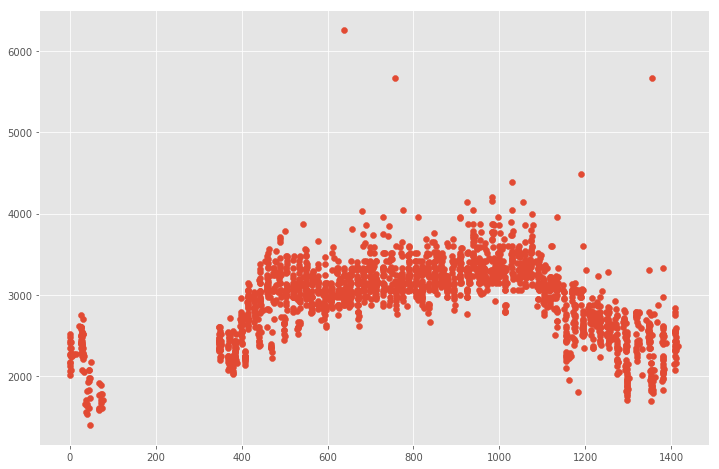

In [177]:
y = time_df['duration'].values.reshape(-1,1)
x = time_df['min_since_midnight'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

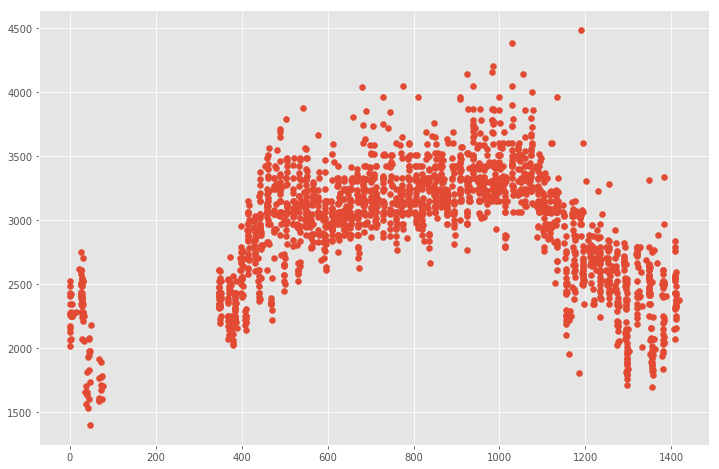

In [178]:
trimed_df = time_df[time_df['duration'] < 4500]

y = trimed_df['duration'].values.reshape(-1,1)
x = trimed_df['min_since_midnight'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

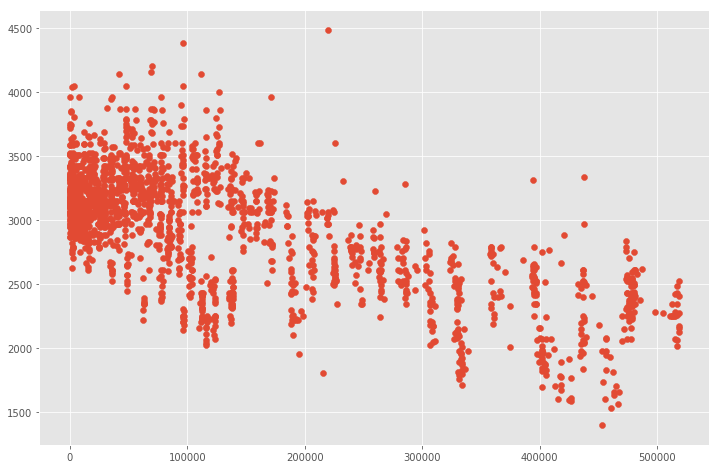

In [179]:
y = trimed_df['duration'].values.reshape(-1,1)
x = trimed_df['min_noon_sqr'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

In [163]:
y = trimed_df['duration'].values.reshape(-1,1)
X = trimed_df['min_noon_sqr'].values.reshape(-1,1)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# Build our model
ridge_cv = RidgeCV(alphas=[5,10,20,30], cv=20)
ridge_cv.fit(X_train, y_train)

#Score our model, R-Squared
r_squared = ridge_cv.score(X_test, y_test)

#Score our model, Root Mean Squared Error
y_predict = ridge_cv.predict(X_test)
rmse_norm = (mean_squared_error(y_test, y_predict))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  0.49
RMSE:  326.27


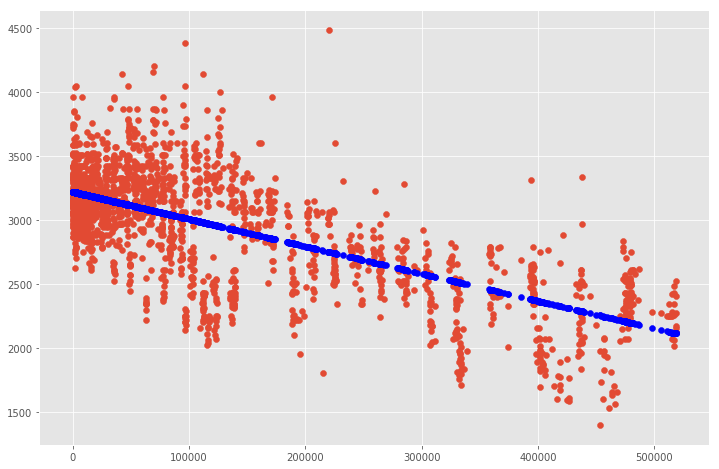

In [164]:
y_pred_totes = ridge_cv.predict(X_norm)
y_pred_stnd = scaler_y.inverse_transform(y_pred_totes)

y = trimed_df['duration'].values.reshape(-1,1)
x = trimed_df['min_noon_sqr'].values.reshape(-1,1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y)
ax.scatter(x, y_pred_stnd, c='blue');

In [180]:
y = trimed_df['duration'].values.reshape(-1,1)
X = trimed_df['min_noon_sqr'].values.reshape(-1,1)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

regr = RandomForestRegressor(n_estimators=50, max_depth=2)

crossed = cross_validate(regr, X_train, y_train.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

r_squared = crossed['test_neg_mean_squared_error'].mean()

#Score our model, Root Mean Squared Error
rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  -0.50
RMSE:  325.14


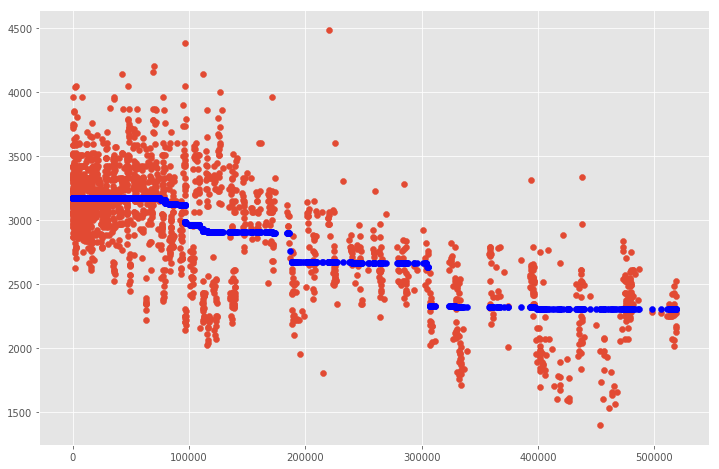

In [182]:
regr.fit(X_train, y_train)

y_pred_totes = regr.predict(X_norm)
y_pred_stnd = scaler_y.inverse_transform(y_pred_totes)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y)
ax.scatter(x, y_pred_stnd, c='blue');

### Okay Cool! But how this relationship play out with different chunks of the trip?

### Let's start with two chunks:

In [188]:
# This will take some time...
two_chunk_data = mdl_util.two_chunk_data(all_trips, trip_coll, chunk_coll)
two_chunk_df = pd.DataFrame(two_chunk_data)
two_chunk_df.head()

,avg_speed_chnk_1,avg_speed_chnk_2,chnk1_mfn_sq_chnk_1,chnk1_mfn_sq_chnk_2,seconds_chnk_1,seconds_chnk_2
0,5.563081,5.117909,481636,452929,1250.0,1027.0
1,5.051780,5.112077,12321,7396,1438.0,1428.0
2,4.878015,3.558431,729,2916,1560.0,1806.0
3,4.676721,3.959559,28900,39204,1682.0,1550.0
4,4.587672,3.931596,96100,114244,1678.0,1534.0


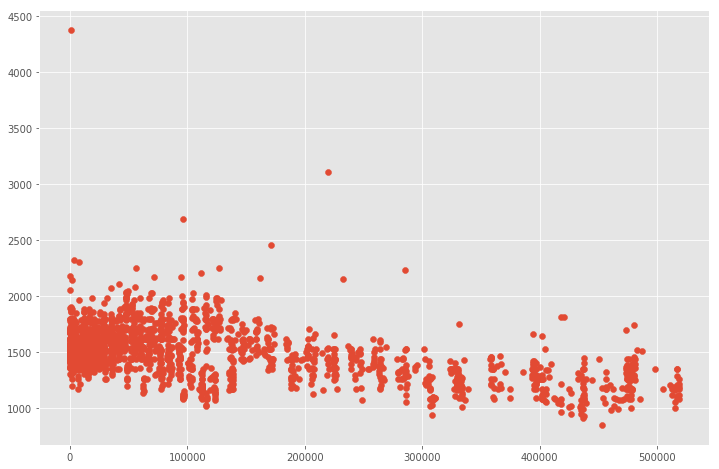

In [190]:
y = two_chunk_df['seconds_chnk_1'].values.reshape(-1,1)
x = two_chunk_df['chnk1_mfn_sq_chnk_1'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

Just as before, we'll need to cleanup some outliers

In [198]:
mask = (two_chunk_df['seconds_chnk_1'] < 2500) & (two_chunk_df['seconds_chnk_2'] < 2500)
trimed_chnk_df = two_chunk_df[mask]

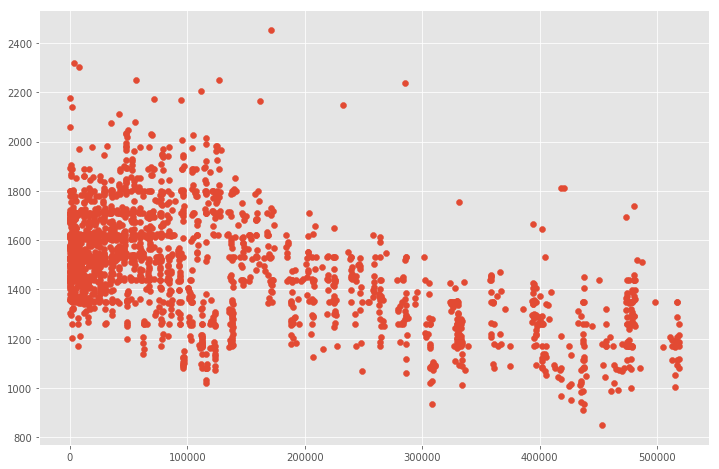

In [199]:
y = trimed_chnk_df['seconds_chnk_1'].values.reshape(-1,1)
x = trimed_chnk_df['chnk1_mfn_sq_chnk_1'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

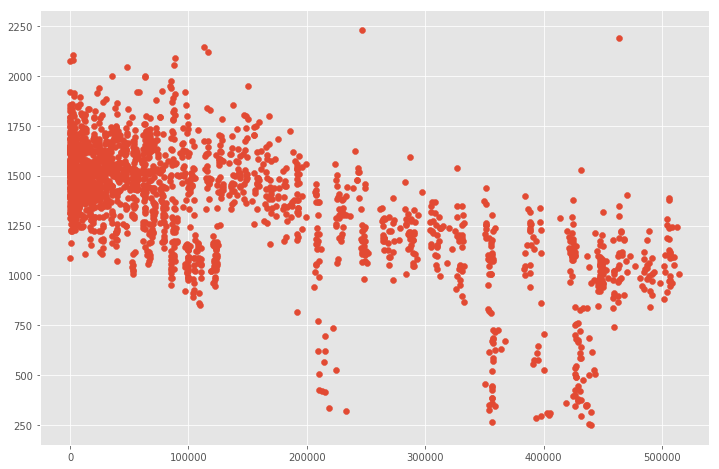

In [200]:
y = trimed_chnk_df['seconds_chnk_2'].values.reshape(-1,1)
x = trimed_chnk_df['chnk1_mfn_sq_chnk_2'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

It seems like the closer we zoom in, the more outliers we get.
